In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, learning_curve, validation_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

In [2]:
path = "https://raw.githubusercontent.com/DSEI21000-S21/project-tennis-ml/main/wta_matches/wta_matches-2000-2021_expanded.csv"

def readData(path):
    df = pd.read_csv(path)
    return df

def dropGibberishRows(dataframe, column_name, filter_variable):
    index_list = list(dataframe[dataframe[column_name] == filter_variable].index)
    dataframe = dataframe.drop(index_list)
    return dataframe

#def encodeColumn(dataframe, column_list = []):
    #df = pd.get_dummies(dataframe, columns= column_list)
    #return df

def convertDate(dataframe, date):
    dataframe[date] = pd.to_datetime(dataframe[date], format = '%Y%m%d', errors='coerce')
    return dataframe

def addDateFeatures(dataframe, date):
    dataframe['year'] = dataframe[date].dt.year
    dataframe['month'] = dataframe[date].dt.month
    dataframe['day'] = dataframe[date].dt.day
    return dataframe

def appendTarget(dataframe, winner, loser):
    dataframe[winner] = 1
    dataframe[loser] = 0
    return dataframe

def getMissingDataPercentage(dataframe):
    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame({'column_name': dataframe.columns,
                                 'percent_missing': percent_missing})
    pd.set_option("max_rows", None)
    return missing_value_df

def formatColumns(dataframe):
    columns = list(dataframe.columns)
    renamed_columns = [i.lower().strip().replace(' ', "_").replace(':','') for i in columns]
    renamed_columns_dict = {columns[i]: renamed_columns[i] for i in range(len(columns))}
    dataframe = dataframe.rename(columns = renamed_columns_dict)
    return dataframe

def convertColumnsToNumeric(dataframe, columns = []):
    dataframe[columns] = dataframe[columns].apply(pd.to_numeric, errors ='coerce')
    return dataframe 

def fillMissingDataMode(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mode().iloc[0])
    return dataframe

def dropColumn(dataframe, column_list = []):
    return dataframe.drop(column_list, axis =1)

def fillMissingDataMean(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mean().iloc[0])
    return dataframe

def fillMissingData999(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(999)
    return dataframe

In [3]:
wta_data = readData(path)
wta_data = dropColumn(wta_data, ['player_entry'])
wta_data = fillMissingDataMode(wta_data, ['surface', 'player_hand'])
wta_data = fillMissingDataMean(wta_data, ['player_height', 'player_age', 'minutes', 'ace', 'double_fault', 'service_points_won', 'first_serve_made', 'first_serve_won', 
'second_serve_won', 'serve_game', 'break_point_saved', 'break_point_faced', 'player_rank','player_rank_points'])
wta_data = fillMissingData999(wta_data, ['player_seed'])
wta_data = convertDate(wta_data, 'tourney_date')
wta_data = addDateFeatures(wta_data, 'tourney_date')
wta_data = dropColumn(wta_data, ['player_ioc', 'score', 'tourney_id', 'tourney_date', 'player_name'])
#wta_data = encodeColumn(wta_data, ['tourney_name','surface', 'tourney_level', 'player_hand','round'])
wta_data = formatColumns(wta_data)

In [4]:
getMissingDataPercentage(wta_data)

,column_name,percent_missing
tourney_name,tourney_name,0.0
surface,surface,0.0
draw_size,draw_size,0.0
tourney_level,tourney_level,0.0
match_num,match_num,0.0
player_id,player_id,0.0
player_seed,player_seed,0.0
player_hand,player_hand,0.0
player_height,player_height,0.0
player_age,player_age,0.0


In [5]:
wta_data.info(verbose =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119438 entries, 0 to 119437
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_name        119438 non-null  object 
 1   surface             119438 non-null  object 
 2   draw_size           119438 non-null  int64  
 3   tourney_level       119438 non-null  object 
 4   match_num           119438 non-null  int64  
 5   player_id           119438 non-null  int64  
 6   player_seed         119438 non-null  float64
 7   player_hand         119438 non-null  object 
 8   player_height       119438 non-null  float64
 9   player_age          119438 non-null  float64
 10  best_of             119438 non-null  int64  
 11  round               119438 non-null  object 
 12  minutes             119438 non-null  float64
 13  ace                 119438 non-null  float64
 14  double_fault        119438 non-null  float64
 15  service_points_won  119438 non-nul

In [6]:
wta_data.describe()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,service_points_won,first_serve_made,first_serve_won,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
count,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000
mean,54.576600,82.883705,202298.029580,678.641488,173.385424,24.219136,3.002579,155.925050,72.479200,73.225291,112.218177,96.664950,87.095960,78.019033,131.635498,73.627145,75.859651,95.349947,1242.600897,0.500000,2009.847620,5.331821,16.041829
std,41.109025,171.380133,3351.576382,463.529275,5.000963,4.647098,0.071770,37.753336,84.053933,83.532933,53.767167,64.975180,72.265931,79.508748,71.195287,83.105517,81.282219,127.100176,1439.037247,0.500002,6.066933,2.911543,8.638772
min,2.000000,1.000000,200001.000000,1.000000,153.000000,14.039699,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000
25%,30.000000,9.000000,201212.000000,11.000000,173.000000,21.122519,3.000000,173.385424,1.000000,3.000000,62.000000,38.000000,24.000000,10.000000,17.000000,3.000000,7.000000,26.000000,391.000000,0.000000,2005.000000,3.000000,8.000000
50%,32.000000,25.000000,201450.000000,999.000000,173.385424,23.956194,3.000000,173.385424,5.000000,6.000000,95.000000,60.000000,38.000000,17.000000,173.385424,8.000000,13.000000,60.000000,777.000000,0.500000,2010.000000,5.000000,16.000000
75%,64.000000,92.000000,201619.000000,999.000000,174.000000,26.964408,3.000000,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,113.000000,1470.000000,1.000000,2015.000000,8.000000,23.000000
max,128.000000,2701.000000,223140.000000,999.000000,189.000000,173.385424,5.000000,2475.000000,173.385424,173.385424,219.000000,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,1482.000000,13615.000000,1.000000,2021.000000,12.000000,31.000000


In [12]:
from google.colab import files
wta_data.to_csv('wta_cleaned_data.csv') 
files.download('wta_cleaned_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
wta_data = pd.read_csv("wta_cleaned_data.csv")
wta_data.head()

,Unnamed: 0,tourney_name,surface,draw_size,tourney_level,match_num,player_id,player_seed,player_hand,player_height,player_age,best_of,round,minutes,ace,double_fault,service_points_won,first_serve_made,first_serve_won,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
0,0,Fed Cup G1 PO: JPN vs CHN,Hard,4,D,1,201419,999.0,R,172.000000,18.173854,3,RR,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,190.0,121.0,1,2000,4,30
1,1,Fed Cup G1 PO: JPN vs CHN,Hard,4,D,2,200085,999.0,R,163.000000,24.821355,3,RR,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,22.0,1230.0,1,2000,4,30
2,2,Fed Cup WG SF: USA vs BEL,Carpet,4,D,1,200652,999.0,L,173.385424,26.973306,3,RR,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,4.0,3255.0,1,2000,11,22
3,3,Fed Cup WG SF: USA vs BEL,Carpet,4,D,2,200128,999.0,R,189.000000,24.457221,3,RR,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,2.0,5022.0,1,2000,11,22
4,4,Fed Cup WG SF: CZE vs ESP,Carpet,4,D,1,200017,999.0,R,173.385424,28.928131,3,RR,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,173.385424,9.0,2132.0,1,2000,11,21


**check for missing values**

In [15]:
#Percentage of missing values
(wta_data.isna().sum() / len(wta_data))*100

Unnamed: 0            0.0
tourney_name          0.0
surface               0.0
draw_size             0.0
tourney_level         0.0
match_num             0.0
player_id             0.0
player_seed           0.0
player_hand           0.0
player_height         0.0
player_age            0.0
best_of               0.0
round                 0.0
minutes               0.0
ace                   0.0
double_fault          0.0
service_points_won    0.0
first_serve_made      0.0
first_serve_won       0.0
second_serve_won      0.0
serve_game            0.0
break_point_saved     0.0
break_point_faced     0.0
player_rank           0.0
player_rank_points    0.0
target                0.0
year                  0.0
month                 0.0
day                   0.0
dtype: float64

In [16]:
# Random Seed
SEED = 42
np.random.seed = SEED

**check if the data is balance**     
target is our target variable, we want to make sure the data is balanced

In [17]:
#check if the data is balance
wta_data['target'].value_counts()

1    59719
0    59719
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


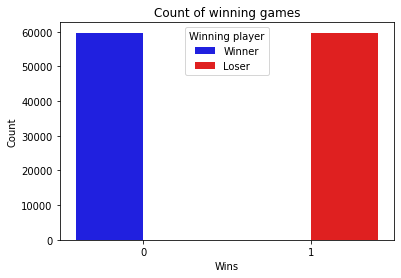

In [18]:
ax = sns.countplot(wta_data['target'], hue=wta_data['target'], palette=['blue', 'red'])
ax.set(xlabel='Wins', ylabel='Count')
ax.legend(title='Winning player', loc='upper center', labels=['Winner', 'Loser'])
ax.set_title('Count of winning games')
plt.show()

**Checking correlation between features**

In [19]:
wta_data_corr = wta_data.corr()
wta_data_corr['target'].sort_values(ascending=False)

target                1.000000e+00
player_rank_points    1.841243e-01
player_height         3.715075e-02
first_serve_won       1.893883e-02
player_age            1.001561e-02
second_serve_won      7.220266e-03
ace                   3.701899e-03
first_serve_made      3.578390e-04
serve_game            2.823581e-04
month                 1.006312e-18
best_of              -1.036141e-19
draw_size            -2.575920e-19
day                  -8.126050e-19
match_num            -4.078054e-18
minutes              -7.204443e-18
year                 -1.129621e-17
double_fault         -2.578640e-03
break_point_saved    -3.247645e-03
service_points_won   -7.119074e-03
break_point_faced    -1.264895e-02
player_id            -4.991135e-02
player_rank          -1.104391e-01
player_seed          -2.060586e-01
Unnamed: 0           -8.660254e-01
Name: target, dtype: float64

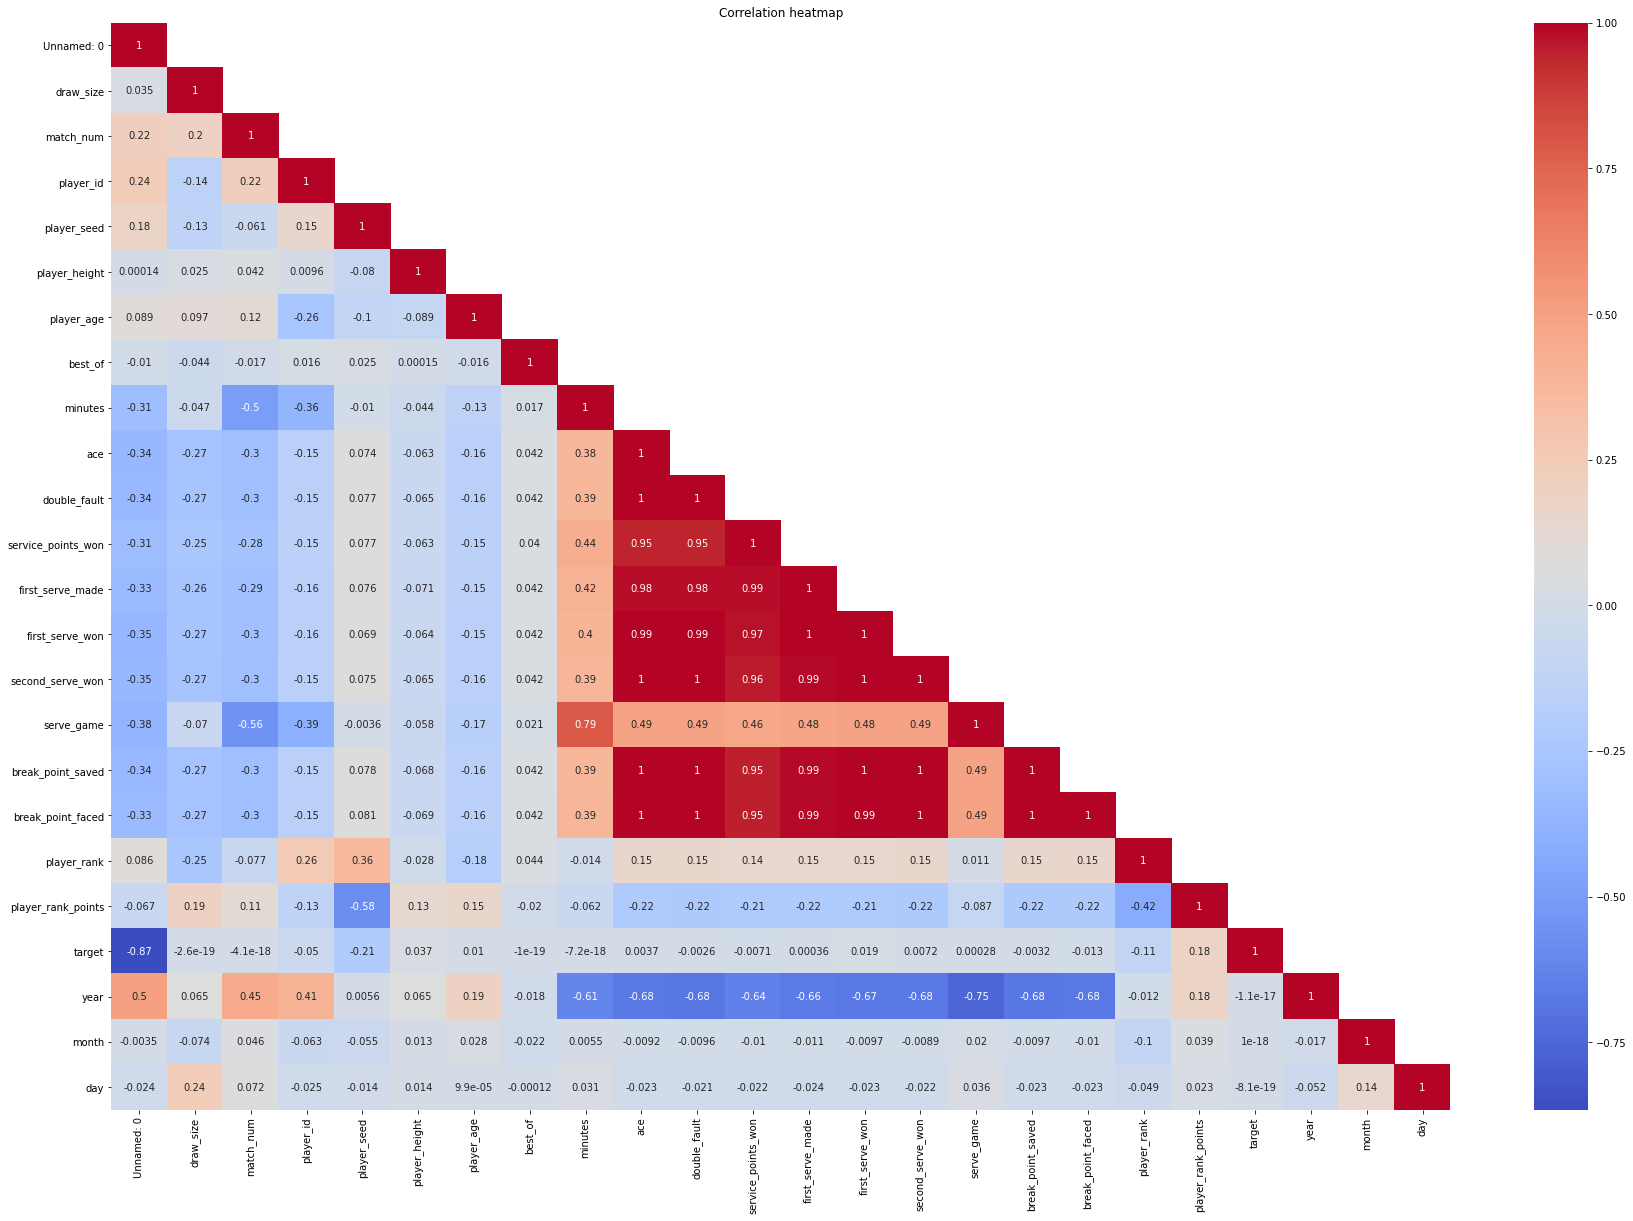

In [20]:
f, ax = plt.subplots(figsize= (30, 20))
lower = wta_data_corr.where(np.tril(np.ones(wta_data_corr.shape)).astype(np.bool))
hmap=sns.heatmap(lower,cmap="coolwarm", annot=True)
ax.set_title('Correlation heatmap')
plt.savefig('clean-corr-half.png')

**player_rank_points** is the highest positively correlated variable to the target variabl whereas **player_seed** is the negatively correlated to the target variable. 

**Convert the categorical columns to numeric**

In [21]:
def encodeColumn(dataframe, column_list = []):
    df = pd.get_dummies(dataframe, columns= column_list)
    return df

In [22]:
wta_data_numerical = encodeColumn(wta_data, ['tourney_name','surface', 'tourney_level', 'player_hand','round'])
wta_data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119438 entries, 0 to 119437
Columns: 2783 entries, Unnamed: 0 to round_SF
dtypes: float64(15), int64(9), uint8(2759)
memory usage: 336.1 MB


**Split data into training and testing sets**

In [25]:
X = wta_data_numerical.loc[:, wta_data_numerical.columns != 'target']
y = wta_data_numerical['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

test_df = pd.concat([X_test, y_test], axis=1) 
train_df = pd.concat([X_train, y_train], axis=1)

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index = False)

print('Labels count in y: ', np.bincount(y))
print('Labels count in y_train ', np.bincount(y_train))
print('Labels count in y_test', np.bincount(y_test))

Labels count in y:  [59719 59719]
Labels count in y_train  [41803 41803]
Labels count in y_test [17916 17916]


**Methodology**

In [26]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [27]:
train_df.columns


Index(['Unnamed: 0', 'draw_size', 'match_num', 'player_id', 'player_seed',
       'player_height', 'player_age', 'best_of', 'minutes', 'ace',
       ...
       'round_BR', 'round_F', 'round_QF', 'round_R128', 'round_R16',
       'round_R32', 'round_R64', 'round_RR', 'round_SF', 'target'],
      dtype='object', length=2783)